# chap7. 시계열 데이터를 다뤄보자

- 웹 트래픽이나 주식 같이 시간의 흐름에 따라 변화하는 데이터를 예측해야 할 상황이 있음.  
- **시계열(time series)** 분석은 통계적으로 어렵고 복잡한 작업.
- 원 데이터의 안정성(stationary)을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구
- 전문가에게 맡기기 전 간단히 데이터를 예측하는 가벼운 도구 : 페이스북에서 만든 **fbprophet** 모듈
- pip으로 설치 필요 : `pystan`, `prophet`

## 7-1 Numpy의 polyfit으로 회귀(regression) 분석하기

- `pip install pandas_datareader`
- `pip install fbprophet`

- `cannot import name 'is_list_like'` 오류는 버전에 따른 오류
- [stack overflow의 답변](https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)대로 해결하면 됨

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet
from datetime import datetime

In [4]:
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    print('Unknown system.')
    
plt.rcParams['axes.unicode_minus'] = False

In [21]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv',
                       encoding='utf-8',
                       thousands=',',
                       names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


- `08. PinkWink Web Traffic.csv`는 책의 저자의 블로그 웹 트래픽 자료

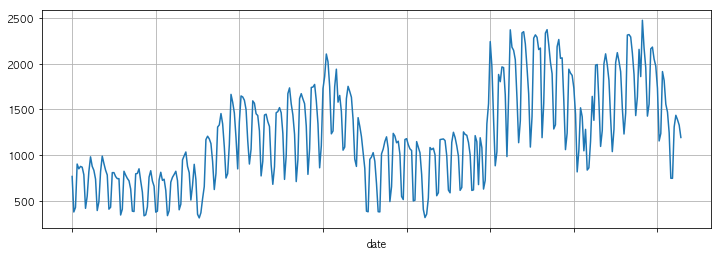

In [22]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

- `;` 을 안찍으면 객체정보도 같이 출력됨

- 단순히 2016년 7월 1일부터 2017년 6월 16일까지 유입량을 그림

In [23]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

- 더 정확한 주기성을 확인
- 먼저 시간축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장

In [24]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

- 어떤 데이터를 어떤 모델로 표현하려면 그 모델의 적합성을 확인하는 과정이 필요
- 참 값을 비교해서 에러를 계산해야 함

In [25]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1 ,time, traffic))
print(error(f2 ,time, traffic))
print(error(f3 ,time, traffic))
print(error(f15 ,time, traffic))

430.8597308110963
430.62841018946955
429.53280466762925
330.4777306662722


- 현재 데이터를 간단한 모델로 표현하는 작업을 **회귀(regression)** 이라고 함.
- 1차, 2차, 3차, 15차 다항식으로 표현한 결과를 확인
- chap1 에서 사용했던  `polyfit`와 `poly1d`를 사ㅛㅇ해서 함수로 표현
- 1차,2차,3차,15차 함수를 확인한 결과 1,2,3차는 에러가 비슷

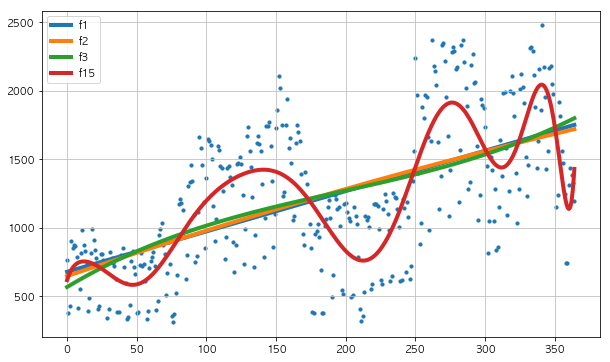

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

- 결과를 그래프로 표현
- 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 나아보임
- 15차 함수를 사용하는 것은 과적합(over-fitting)

## 7-2 Prophet 모듈을 이용한  forecase 예측

- pinkwink_web 변수에서 날짜(index)와 방문서(hit)만 따로 저장

In [29]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%y. %m. %d.')
del df['date']

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

- pandas가 지원하는 to_datetime 함수를 이용해 날짜라고 선언
- Prophet 함수를 사용할 때 주기성이 연단위(yearly_seasonality)로 있다고 알려줌

In [30]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


- `make_future_dataframe(periods=60)` : 이후 60일간의 데이터를 예측

In [31]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,910.186265,678.794327,1111.894459
421,2017-08-26,495.150075,294.255762,701.959687
422,2017-08-27,627.716799,411.512915,827.719790
423,2017-08-28,1180.359753,961.014450,1401.512872
424,2017-08-29,1216.280229,1002.952737,1439.516338


- 예측한 데이터를 forecast 변수에 저장

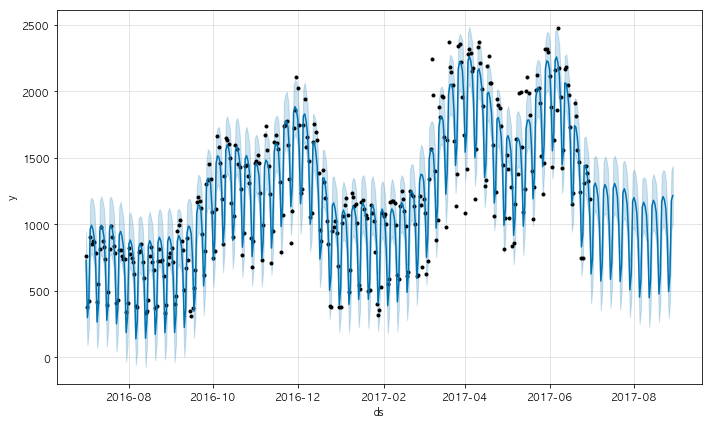

In [32]:
m.plot(forecast);

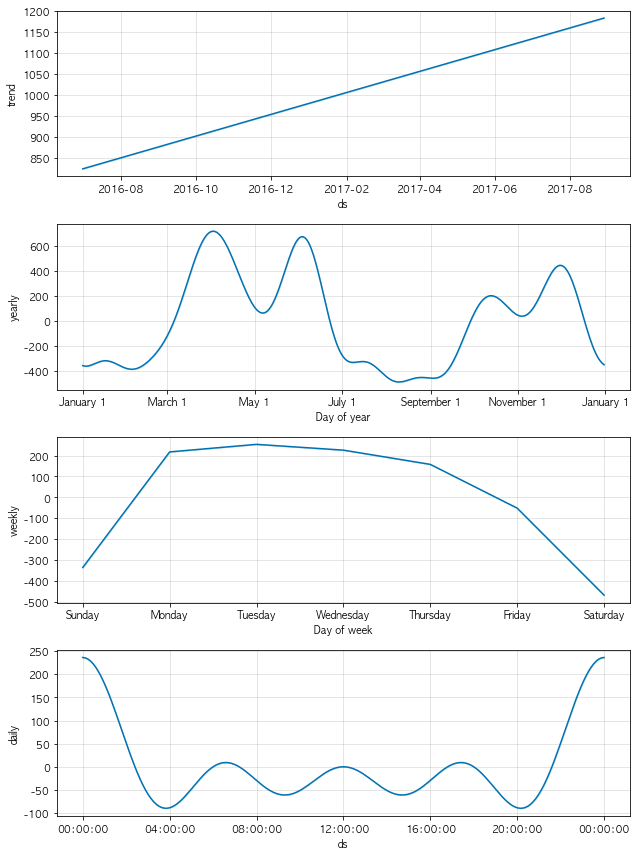

In [33]:
m.plot_components(forecast);

- 빈약하긴 하지만 이러한 과정을 **Seasonal 시계열 데이터 분석(Seasonal Time Series Data Analysis)**라고 함